[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/imeri-course/ai-in-healthcare/blob/master/Session4/Demo_GAN.ipynb)

In [1]:
import numpy as np
import os
import time
%matplotlib inline
import matplotlib.pyplot as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as om
import torchvision as tv
import torch.utils.data as dat

if torch.cuda.is_available():     # Make sure GPU is available
    dev = torch.device("cuda:0")
    kwar = {'num_workers': 8, 'pin_memory': True}
    cpu = torch.device("cpu")
else:
    print("Warning: CUDA not found, CPU only.")
    dev = torch.device("cpu")
    kwar = {}
    cpu = torch.device("cpu")

np.random.seed(551)

# Table of Content
1.  About Medical MNIST Dataset
1.  Exploratory Data Analysis (EDA)
    1.  Data Info
    1.  Check Sample Image
1.  Data Preparation
    1.  Convert to dataframe
    1.  Create Data Abstraction
    1.  Create Data Transform Pipeline
    1.  Compose all to DataLoader
1.  Training Preparation
    1.  Create Model Architecture
        1. Generator Architecture
        1. Discriminator Architecture
    1.  Set Training Model
    1.  Set Optimizer
    1.  Set Criterion
1.  Training
1.  Results
    1.  Plot Result

# 1. About Medical MNIST Dataset

This dataset is a simple MNIST-style medical images in 64x64 dimension;
There were originaly taken from other datasets and processed into such style. There are 58954 medical images belonging to 6 classes.

![Medical MNIST](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F793761%2F80e9bd2c92dbd64518c8f7be18d57b81%2FUntitled.png?generation=1587494186344589&alt=media)

We want to generate same data to be like this <br>
![](sample_dcgan.gif)

Resource Dataset : [Medical-MNIST-Classification](https://github.com/apolanco3225/Medical-MNIST-Classification%7D%7D)

# 2. Exploratory Data Analysis (EDA)

In [ ]:
# Download data
!wget https://github.com/imeri-course/ai-in-healthcare/raw/master/Session3/mednist_dataset.zip
!unzip mednist_dataset.zip

## 2.1. Data Info

In [2]:
from pathlib import Path
from PIL import Image
ROOT_DATA = 'mednist'
data_path = Path(ROOT_DATA)
import random

# get Class Name
class_names = [d.name for d in data_path.iterdir()]

# get number class
num_class = len(class_names)

# get all image_file
image_files = list(data_path.rglob('*.jpeg'))

# get all image perclass
dict_file = {}
for c in class_names:
    dict_file[c] = list(data_path.rglob('{}/*.jpeg'.format(c)))

# get image width and height
image_width, image_height = Image.open(image_files[0]).size

# print all
print(f'There are {len(image_files)} images in {len(class_names)} distinct categories')
print(f'Image Dimensions : {image_width} x {image_height}')
print('Total image perclass:')
for c in class_names:
    print("Label {0:9} : {1}".format(c,len(dict_file[c])))

There are 58954 images in 6 distinct categories
Image Dimensions : 64 x 64
Total image perclass:
Label ChestCT   : 10000
Label AbdomenCT : 10000
Label HeadCT    : 10000
Label BreastMRI : 8954
Label CXR       : 10000
Label Hand      : 10000


## 2.2. Check Sample Image

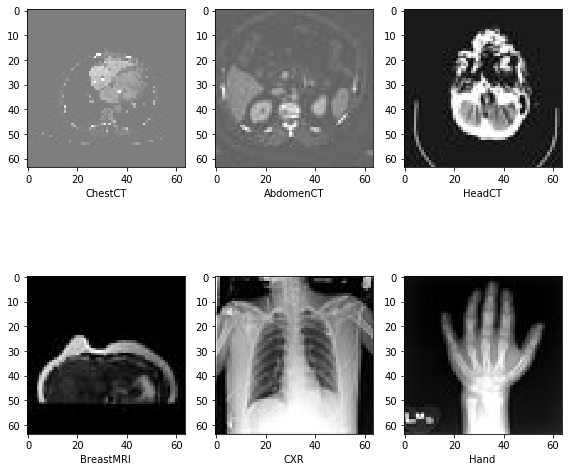

In [3]:
mp.subplots(2,3,figsize=(8,8))
for i, c in enumerate(class_names):
    im = Image.open(dict_file[c][random.randint(0, len(dict_file[c]))])
    arr = np.array(im)
    mp.subplot(2,3,i+1)
    mp.xlabel(c)
    mp.imshow(arr,cmap='gray',vmin=0,vmax=255)
mp.tight_layout()
mp.show()

# 3. Data Preparation

![data preprocessing](../Session3/pytorch_data_pipeline.png)

## 3.1. Convert to dataframe

In [4]:
import pandas as pd

# Convert data to list
list_data = []
for k, v in dict_file.items():
    for f in v:
        _dict = {'filename': f, 'class_name': k}
        list_data.append(_dict)

# To pandas dataframe
df_file_class = pd.DataFrame(list_data)

In [5]:
df_file_class.sample(5)

,filename,class_name
26775,/home/muchlisinadi/Documents/Projects/course/i...,HeadCT
53463,/home/muchlisinadi/Documents/Projects/course/i...,Hand
18441,/home/muchlisinadi/Documents/Projects/course/i...,AbdomenCT
15533,/home/muchlisinadi/Documents/Projects/course/i...,AbdomenCT
24877,/home/muchlisinadi/Documents/Projects/course/i...,HeadCT


## 3.2. Create Data Abstraction

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class MedicalMNIST(Dataset):
    CLASS = {'HeadCT': 0, 'BreastMRI': 1, 'AbdomenCT':2, 'CXR':3, 'ChestCT':4, 'Hand':5}
    
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.df.iloc[idx].filename
        labels = self.df.iloc[idx].class_name
        
        # convert to class_id
        labels = self.CLASS[labels]
        
        # load image using PIL
        image = Image.open(file_name)
        
        # if any transform
        if self.transform:
            image = self.transform(image)
            
        return image, labels

## 3.3. Create Data Transform Pipeline

In [7]:
# List transform pipeline
_transform = []
_transform.append(transforms.ToTensor()) # Convert (from 0-255 to 0-1) and tensor datatype
_transform.append(transforms.Normalize(mean=(0.5,), std=(0.5,))) # normalize each data with same mean and std

# compose all to one function
transform = transforms.Compose(_transform)

## 3.4. Compose all to DataLoader
Sometimes one epoch is too big to feed to the computer at once we divide it in several smaller batches. <br>
`Epoch` = **One Epoch** is when an **ENTIRE dataset** is passed **forward** and **backward** through the neural network **only ONCE**. <br>
`Batch Size` = Total number of training examples present **in a single batch**.

In [8]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Parameter batch_size
batch_size = 100

dataset = MedicalMNIST(df_file_class, transform)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last = True)

In [9]:
# get sample data
examples = enumerate(dataloader)
batch_idx, (example_data, example_targets) = next(examples)

In [10]:
batch_idx

0

In [11]:
example_data.shape

torch.Size([100, 1, 64, 64])

In [12]:
example_targets.shape

torch.Size([100])

# 4. Training Preparation

## 4.1 Create Model Architecture

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

from torch.autograd import Variable
from torchvision.utils import save_image

### 4.1.1. Generator Architecture
![Generator](generator_dcgan.png)

In [ ]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, z_dim, n_channel, ngf ):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, n_channel, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### 4.1.2. Discriminator Architecture
![Discriminator](discriminator_dcgan.png)

In [36]:
# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, z_dim, n_channel, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(n_channel, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

## 4.2. Set Training Model

In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# build network
z_dim = 100
ngf = 64
ndf = 64
n_channel = 1

G = Generator(z_dim=z_dim, n_channel=n_channel, ngf=ngf).to(device)
D = Discriminator(z_dim=z_dim, n_channel=n_channel, ndf=ndf).to(device)

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Intitiate all weight
G.apply(weights_init)
D.apply(weights_init)

## 4.3. Set Optimizer

In [16]:
# optimizer
lr = 0.0002 
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

## 4.4. Set Criterion
![bce_loss](bce_loss.png)

If we set:
- `real_label = 1` on y: <br>
$1logX_{n}+(1-1)log(1-x_{n}) \rightarrow  logX_{n}$

- `fake_label = 0` on :<br>
$0logX_{n}+(1-0)log(1-x_{n}) \rightarrow  log(1-x_{n})$

loss Function for gan training: 
1. At Discriminator D
$ Dloss_{real} = log(D(x))) $ <br>
$ Dloss_{fake} = log(1-D(G(z))) $<br>
$ Dloss = Dloss_{real}+Dloss_{fake} \equiv  log(D(x))) + log(1-D(G(z))) $ <br>

1. At Generator G
$ Gloss = log(D(x))) $ <br>

In [17]:
# Binary Cross Entropy loss
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# 5. Training

![Gan Training](https://miro.medium.com/max/3200/1*M_YipQF_oC6owsU1VVrfhg.jpeg)

In [18]:
# Create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

def generate_data(epoch):
    with torch.no_grad():
        generated = G(fixed_noise)
        save_image(generated.view(generated.size(0), 1, 64, 64), './samples/sample_'+ str(epoch) + '.png')

In [19]:
# Training Loop
# Lists to keep track of progress
G_losses = []
D_losses = []
n_epoch = 1
print("Starting Training Loop...")
# For each epoch
len_dataloader = len(dataloader)
for epoch in range(n_epoch):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        # get actual batch_size
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        # create label countainer
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=device)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        label.fill_(real_label) # Fill label countainer with true_label
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = G(noise)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        label.fill_(fake_label) # Fill label countainer with true_label
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        label.fill_(real_label)  # Fill label countainer with true_label
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epoch, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
    # save sample result per epoch
    generate_data(epoch)

Starting Training Loop...
[0/1][0/589]	Loss_D: 1.7437	Loss_G: 5.0138	D(x): 0.4815	D(G(z)): 0.5333 / 0.0093
[0/1][50/589]	Loss_D: 0.1291	Loss_G: 11.9170	D(x): 0.9136	D(G(z)): 0.0012 / 0.0000


KeyboardInterrupt: 

# 6. Results

In [24]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

def plot_(train, test=None, xlabel="epoch", ylabel="loss", title="Result Training", rolling=200):
    """
    Function for plot the result
    """
    df = pd.DataFrame()
    df['train'] = train
    df = df.rolling(rolling).mean()
    if test:
        df['test'] = test
    sns.lineplot(hue="region", style="event",data=df)
    # other info
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## 6.1. Plot Result

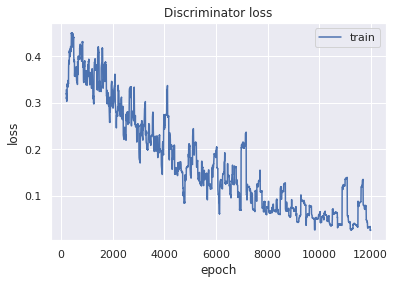

In [33]:
# Check Loss
plot_(D_losses, title="Discriminator loss")

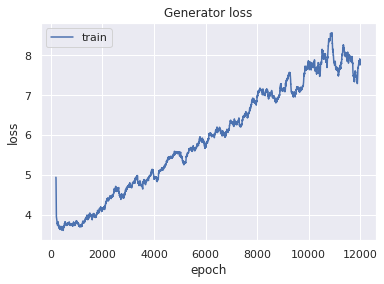

In [34]:
# Check Loss
plot_(G_losses, title="Generator loss")